<a href="https://colab.research.google.com/github/marianageh/SWE_MariaNageh_20190403/blob/main/%5CSuperVisedLearning_Ass2_20190403_20190599_S5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


*   *Maria Nageh Gergis*
      20190403   S5
*   *Nourhan Samir *           
  20190599   *S5*




In [ ]:
import numpy as np
from scipy import signal
from sklearn.metrics import accuracy_score
from keras.datasets import mnist
from keras.utils import np_utils
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

In [ ]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        pass

    def backward(self, output_gradient, learning_rate):
        pass


In [ ]:
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))



In [ ]:
class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)

class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)


In [ ]:
class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient


In [ ]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

In [ ]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)


In [ ]:
class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

In [ ]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")

In [ ]:
def preprocess_data(x, y, limit):
    # reshape and normalize input data
    x = x.reshape(x.shape[0], 28 * 28, 1)
    x = x.astype("float32") / 255
    # encode output which is a number in range [0,9] into a vector of size 10
    # ex 1 -> [1 0 0 0 0 0 0 0 0 0]
    #    2 -> [0 1 0 0 0 0 0 0 0 0]
    y = np_utils.to_categorical(y)
    y = y.reshape(y.shape[0], 10, 1)
    return x[:limit], y[:limit]


# load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 1000)
x_test, y_test = preprocess_data(x_test, y_test, 20)

# neural network
network = [
    Dense(28 * 28, 40),
    Tanh(),
    Dense(40, 10),
    Tanh()
]

# train
train(network, mse, mse_prime, x_train, y_train, epochs=100, learning_rate=0.05)

# test
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    print('pred:', np.argmax(output), '\ttrue:', np.argmax(y))

11501568/11490434 [==============================] - 0s 0us/step
1/100, error=0.9453177510017542
2/100, error=0.8051564247948289
3/100, error=0.7571434127343135
4/100, error=0.7230278323818345
5/100, error=0.6915132452891221
6/100, error=0.6607459154834232
7/100, error=0.6196851383124328
8/100, error=0.5762685890874063
9/100, error=0.5339591702633344
10/100, error=0.4879992120225917
11/100, error=0.43782068648134687
12/100, error=0.3908501520499231
13/100, error=0.3460351203616619
14/100, error=0.3034923572256277
15/100, error=0.26762507891852105
16/100, error=0.23347636297970698
17/100, error=0.2004881687976095
18/100, error=0.17007265713065342
19/100, error=0.14852438823772823
20/100, error=0.13393108530271425
21/100, error=0.11824701508396752
22/100, error=0.10317905186500308
23/100, error=0.09444116158585458
24/100, error=0.09065481888726508
25/100, error=0.08826340968218588
26/100, error=0.08641400577268733
27/100, error=0.08508061833853797
28/100, error=0.08410853068108524
29/100

In [ ]:
def preprocess_data(x, y, limit):
    zero_index = np.where(y == 0)[0][:limit]
    one_index = np.where(y == 1)[0][:limit]
    all_indices = np.hstack((zero_index, one_index))
    all_indices = np.random.permutation(all_indices)
    x, y = x[all_indices], y[all_indices]
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype("float32") / 255
    y = np_utils.to_categorical(y)
    y = y.reshape(len(y), 2, 1)
    return x, y

# load MNIST from server, limit to 100 images per class since we're not training on GPU
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 100)
x_test, y_test = preprocess_data(x_test, y_test, 100)

# neural network
network = [
    Convolutional((1, 28, 28), 3, 5),
    Sigmoid(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 2),
    Sigmoid()
]

# train
train(
    network,
    binary_cross_entropy,
    binary_cross_entropy_prime,
    x_train,
    y_train,
    epochs=100,
    learning_rate=0.05
)

# test
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")

1/100, error=0.41233483400875665
2/100, error=0.11781419557024803
3/100, error=0.08302445960280418
4/100, error=0.056074919109540516
5/100, error=0.03815896720434035
6/100, error=0.03858064677279237
7/100, error=0.02779394407765142
8/100, error=0.020646024558480622
9/100, error=0.017169560131027578
10/100, error=0.014116147752935264
11/100, error=0.01269681864071417
12/100, error=0.011241647279215023
13/100, error=0.010088969960151737
14/100, error=0.008834200818570687
15/100, error=0.0078944979012106
16/100, error=0.007106217471364945
17/100, error=0.006477376078749163
18/100, error=0.005959792316938966
19/100, error=0.005527546629013427
20/100, error=0.005158274618609638
21/100, error=0.004837848128770293
22/100, error=0.004556994622278244
23/100, error=0.004309054982681545
24/100, error=0.004088680080362609
25/100, error=0.0038913711986811473
26/100, error=0.0037133949269651688
27/100, error=0.0035517368091739416
28/100, error=0.00340402924578806
29/100, error=0.0032684570518330264


Streaming output truncated to the last 5000 lines.
5001/10000, error=8.401790416776646e-05
5002/10000, error=8.399859486468719e-05
5003/10000, error=8.397929401281906e-05
5004/10000, error=8.396000160671562e-05
5005/10000, error=8.394071764094168e-05
5006/10000, error=8.392144211006092e-05
5007/10000, error=8.390217500864601e-05
5008/10000, error=8.38829163312717e-05
5009/10000, error=8.386366607251712e-05
5010/10000, error=8.384442422696864e-05
5011/10000, error=8.382519078921493e-05
5012/10000, error=8.380596575384933e-05
5013/10000, error=8.378674911547107e-05
5014/10000, error=8.376754086868266e-05
5015/10000, error=8.374834100809127e-05
5016/10000, error=8.372914952831058e-05
5017/10000, error=8.37099664239557e-05
5018/10000, error=8.369079168964843e-05
5019/10000, error=8.367162532001425e-05
5020/10000, error=8.36524673096849e-05
5021/10000, error=8.363331765329449e-05
5022/10000, error=8.36141763454821e-05
5023/10000, error=8.359504338089279e-05
5024/10000, error=8.3575918754174

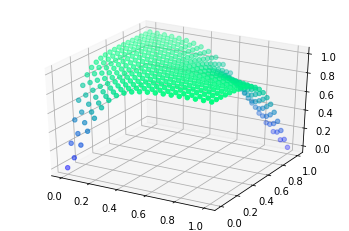

In [ ]:
X = np.reshape([[0, 0], [0, 1], [1, 0], [1, 1]], (4, 2, 1))
Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

network = [
    Dense(2, 3),
    Tanh(),
    Dense(3, 1),
    Tanh()
]

# train
train(network, mse, mse_prime, X, Y, epochs=10000, learning_rate=0.05)

# decision boundary plot
points = []
for x in np.linspace(0, 1, 20):
    for y in np.linspace(0, 1, 20):
        z = predict(network, [[x], [y]])
        points.append([x, y, z[0,0]])

points = np.array(points)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 2], cmap="winter")
plt.show()
